In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
## 한글 설정
plt.rc('font', family='D2coding')

In [33]:
## csv 파일 불러오기
abandoned = pd.read_csv('유기동물보호현황.csv', encoding='cp949')
abandoned[:1]

,시군명,접수일자,발견장소,상태,공고고유번호,공고시작일자,공고종료일자,품종,색상,나이,...,보호소전화번호,보호소도로명주소,보호소지번주소,보호소우편번호,관할기관,특이사항,이미지경로,썸네일이미지경로,WGS84위도,WGS84경도
0,오산시,20230514,성호대로141,보호중,경기-오산-2023-00116,20230514,20230524,[고양이] 한국 고양이,치즈색,2023(60일미만)(년생),...,031-372-9325,경기도 오산시 성호대로 36,경기도 오산시 오산동 609-55번지,18130,경기도 오산시,NaN,http://www.animal.go.kr/files/shelter/2023/05/...,http://www.animal.go.kr/files/shelter/2023/05/...,37.149089,127.065203


In [34]:
## 컬럼 정리
abandoned.drop(columns=['발견장소', '공고고유번호', '공고시작일자', '공고종료일자'
                       , '특징', '보호소명', '보호소전화번호', '보호소도로명주소', '보호소지번주소', '보호소우편번호'
                       , '이미지경로', '썸네일이미지경로', 'WGS84위도', 'WGS84경도', '특이사항', '관할기관'], inplace=True)

In [280]:
## 접수일자 컬럼 dtype 변경 : int -> str -> datetime
abandoned.접수일자 = abandoned.접수일자.astype('str')
abandoned.접수일자 = pd.to_datetime(abandoned['접수일자'])

## datetime format 변경
abandoned.접수일자 = abandoned.접수일자.dt.strftime('%Y-%m')

## 2022년 11월과 2023년 5월 데이터 삭제 -> 맞을지...

In [281]:
## 잘못 표시된 값 수정 : U -> Q
abandoned.loc[abandoned.중성화여부 == 'U', '중성화여부'] = 'Q'
abandoned.체중 = abandoned.체중.str.replace('(Kg)', '').str.replace(',', '.').str.replace('..', '.').str.replace("\'", "")
# abandoned[abandoned['체중'] == '.5.9']
# abandoned[abandoned['체중'] == '6.3.']
abandoned.loc[6735, '체중'] = '5.9'
abandoned.loc[7146, '체중'] = '6.3'

In [282]:
## 체중 컬럼 dtype 변경 : object -> float
abandoned.체중 = abandoned.체중.apply(float)

In [283]:
## 작년기준 60일 미만 유기동물들의 나이는 2022년생으로 수정
abandoned.loc[abandoned.나이 == '2022(60일미만)(년생)', '나이'] = '2022(년생)'

## 나이컬럼 수정 : n(년생) -> (2023 - n + 1)살, 60일 미만 -> 0살
abandoned.나이 = abandoned.나이.str.replace('(년생)', '')
abandoned.loc[abandoned.나이 == '2023(60일미만)', '나이'] = '2024'
abandoned.나이 = abandoned.나이.astype('int16')
abandoned.나이 = 2023 - abandoned.나이 + 1

In [19]:
## 컬럼 추가 : 품종상세
abandoned['품종상세'] = abandoned.품종

abandoned.loc[abandoned.품종상세.str.contains(r'\[고양이\]'), '품종상세'] = '고양이'
abandoned.loc[abandoned.품종상세.str.contains(r'\[개\]'), '품종상세'] = '개'
abandoned.loc[abandoned.품종상세.str.contains(r'\[기타축종\]'), '품종상세'] = '기타축종'

In [23]:
abandoned.loc[:, '품종상세'] = abandoned.품종상세.str.replace('[고양이]', '').str.replace('[개]', '').str.replace('[기타축종]', '')

In [285]:
## 컬럼 이름 변경
abandoned.rename(columns={'품종': '품종상세', '품종상세': '품종'}, inplace=True)

In [51]:
## 컬럼순서 조정
abandoned = abandoned[['시군명', '접수일자', '상태', '품종', '품종상세', '나이', '체중', '성별', '중성화여부']]

In [32]:
## csv 파일 저장
abandoned.to_csv('abandoned.csv', index=False, encoding='UTF-8')

In [33]:
abandoned = pd.read_csv('abandoned.csv')

성별 Q = 알수없음 중성화여부 Q = 알수없음

In [34]:
abandoned[:5]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
0,오산시,2023-05,보호중,고양이,한국 고양이,0,0.11,Q,N
1,오산시,2023-05,보호중,고양이,한국 고양이,0,0.10,Q,N
2,남양주시,2023-05,보호중,개,셰퍼드,3,24.00,F,N
3,남양주시,2023-05,보호중,개,셰퍼드,3,27.00,M,N
4,성남시,2023-05,보호중,고양이,터키시 앙고라,1,1.10,F,Q


In [4]:
abandoned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시군명     9127 non-null   object 
 1   접수일자    9127 non-null   object 
 2   상태      9127 non-null   object 
 3   품종상세    9127 non-null   object 
 4   품종      9127 non-null   object 
 5   나이      9127 non-null   int64  
 6   체중      9127 non-null   float64
 7   성별      9127 non-null   object 
 8   중성화여부   9127 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 641.9+ KB


In [46]:
## 품종 분류 : 고양이
abandoned_cat = abandoned[abandoned.품종.str.contains(r'\[고양이\]')]
abandoned_cat[:2]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
0,오산시,2023-05,보호중,[고양이]한국고양이,0,0.11,Q,N
1,오산시,2023-05,보호중,[고양이]한국고양이,0,0.10,Q,N


In [47]:
## 품종 분류 : 개
abandoned_dog = abandoned[abandoned.품종.str.contains(r'\[개\]')]
abandoned_dog[:2]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
2,남양주시,2023-05,보호중,[개]셰퍼드,3,24.0,F,N
3,남양주시,2023-05,보호중,[개]셰퍼드,3,27.0,M,N


In [48]:
## 품종 분류 : 기타축종
abandoned_other = abandoned[abandoned.품종.str.contains(r'\[기타축종\]')]
abandoned_other[:2]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
81,성남시,2023-05,종료(자연사),[기타축종]햄스터,2,0.01,Q,N
220,고양시,2023-05,보호중,[기타축종]앵무새,2,0.03,Q,Q


In [71]:
abandoned[:5]

,시군명,접수일자,상태,품종상세,품종,나이,체중,성별,중성화여부
0,오산시,2023-05,보호중,한국 고양이,고양이,0,0.11,Q,N
1,오산시,2023-05,보호중,한국 고양이,고양이,0,0.10,Q,N
2,남양주시,2023-05,보호중,셰퍼드,개,3,24.00,F,N
3,남양주시,2023-05,보호중,셰퍼드,개,3,27.00,M,N
4,성남시,2023-05,보호중,터키시 앙고라,고양이,1,1.10,F,Q


가설
1. 유기동물의 수는 달마다 꾸준히 증가했을 것이다
1. 유기동물의 종류는 개가 가장 많을 것이다
1. 개의 품종은 믹스견이 가장 많을 것이다
1. 나이가 1살 이하인 동물들의 수가 많을 것이다
1. 보호 종료 사유로는 안락사의 비율이 월등히 높을 것이다
1. 성별/중성화여부 관련

자료기간 : 2022-11-15 ~ 2023-05-14

 「동물보호법」 제40조에 따른 공고가 있는 날부터 10일이 지나도 소유자등을 알 수 없는 경우에는
「유실물법」 제12조 및 「민법」 제253조에도 불구하고 해당 시ㆍ도지사 또는 시장ㆍ군수ㆍ구청장이 그 동물의 소유권을 취득하게 됩니다.

안락사에 관한 공식적인 가이드라인은 없는 상태. 개별 수의사에게 맡겨진 셈임

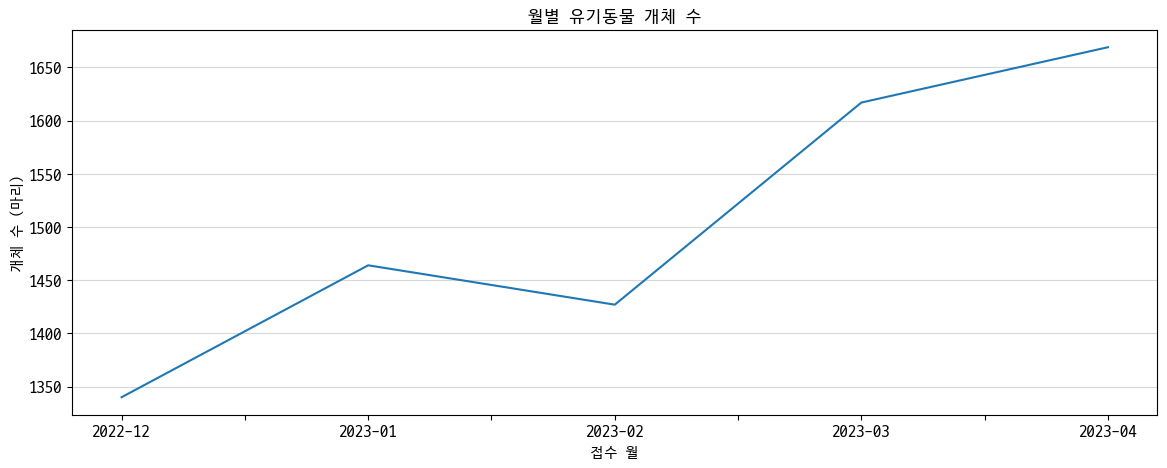

In [77]:
## [가설 1] 유기동물의 수는 꾸준히 증가했을 것이다
## 22년 11월 15일부터 23년5월 14일까지의 데이터
## -> 5월, 11월 제외?

abandoned.drop(abandoned[abandoned.접수일자.isin(['2023-05', '2022-11'])].index).groupby('접수일자').접수일자.value_counts().plot(
    kind='line',
    title='월별 유기동물 개체 수',
    rot=0,
    figsize=(14, 5),
    fontsize=12,
)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('접수 월')
plt.ylabel('개체 수 (마리)')
plt.show()

In [112]:
abandoned.groupby('접수일자').size().to_frame()

,0
접수일자,
2022-11,815
2022-12,1340
2023-01,1464
2023-02,1427
2023-03,1617
2023-04,1669
2023-05,795


## [가설 1] 달별 유기동물의 수는 꾸준히 증가했을 것이다
- 경기도 내 유기동물의 수는 2022년 12월부터 상승 하였으나, 2023년 1월 1464마리에서 2023년 2월 1427 마리로 하락하였다. 이후 2023년 3월 1617마리, 2023년 4월 1669마리로 지속 상승하였다.
- 

<Axes: title={'center': '유기동물 품종 비율'}>

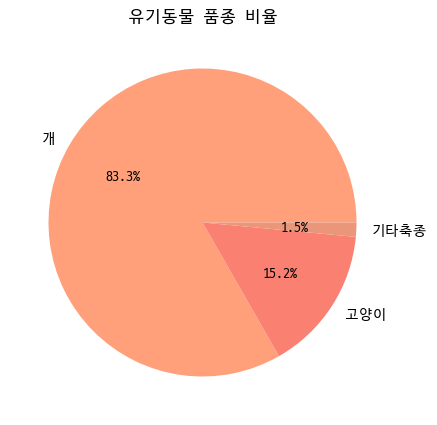

In [72]:
## [가설 2] 유기동물의 종류는 개가 가장 많을 것이다  -> 개, 고양이, 기타축종
abandoned.groupby('품종').size().sort_values(ascending=False).plot(
    kind='pie',
    title='유기동물 품종 비율',
    figsize=(5, 5),
    autopct='%.1f%%',
    colors=['#FFA07A', '#FA8072', '#E9967A'],
    #colormap='BuPu',
)

Text(0, 0.5, '개체 수 (마리)')

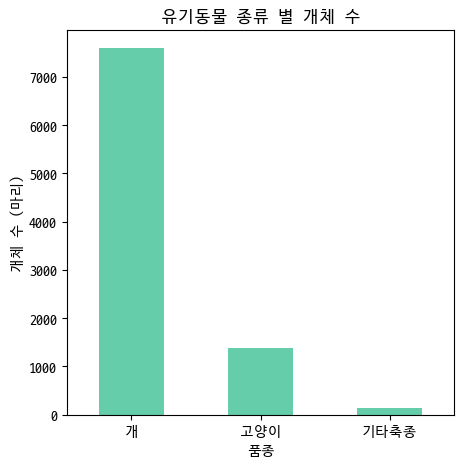

In [73]:
abandoned.groupby('품종').size().sort_values(ascending=False).plot(
    kind='bar',
    title='유기동물 종류 별 개체 수',
    rot=0,
    figsize=(5, 5),
    width=0.5,
    color='#66CDAA',
)
plt.ylabel('개체 수 (마리)')

In [81]:
abandoned.groupby('품종').size()

품종
개       7600
고양이     1391
기타축종     136
dtype: int64

## [가설 2] 유기동물의 종류는 개가 가장 많을 것이다
- 유기동물의 품종은 개가 85.1%, 고양이가 13.4%, 기타축종이 1.5%로 개의 비율이 가장 높았다.
-

<Axes: title={'center': '유기견 상위 10개 품종'}>

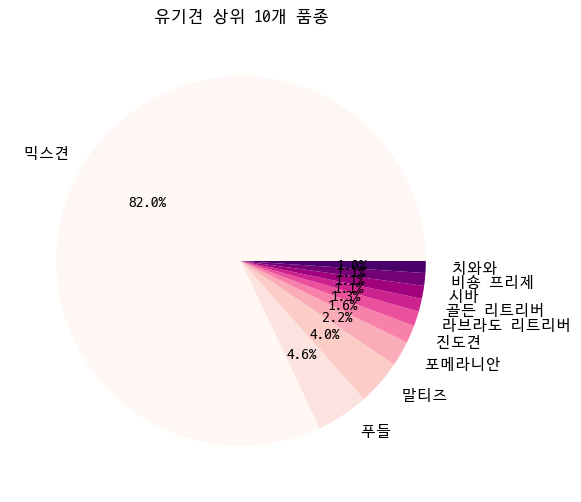

In [74]:
## [가설 3] 개의 품종은 믹스견이 가장 많을 것이다
## 방법 생각좀 해보자
abandoned[abandoned.품종 == '개'].groupby('품종상세').size().sort_values(ascending=False)[:10].plot(
    kind='pie',
    title='유기견 상위 10개 품종',
    autopct='%.1f%%',
    figsize=(6, 6),
    fontsize=11,
    colormap='RdPu'
)

In [5]:
abandoned[abandoned.품종 == '개'].groupby('품종상세').size()

품종상세
 골든 리트리버      78
 그레이 하운드       4
 그레이트 피레니즈     5
 닥스훈트         25
 달마시안          2
              ..
 풍산견          36
 프렌치 불독       55
 핏불테리어         2
 화이트테리어        1
 휘펫            1
Length: 90, dtype: int64

## [가설 3] 유기견의 품종은 믹스견이 가장 많을 것이다
- 유기견 90종류 중 개체 수 상위 10개 품종에서 믹스견이 82%로 가장 높은 비율을 보였다.
-

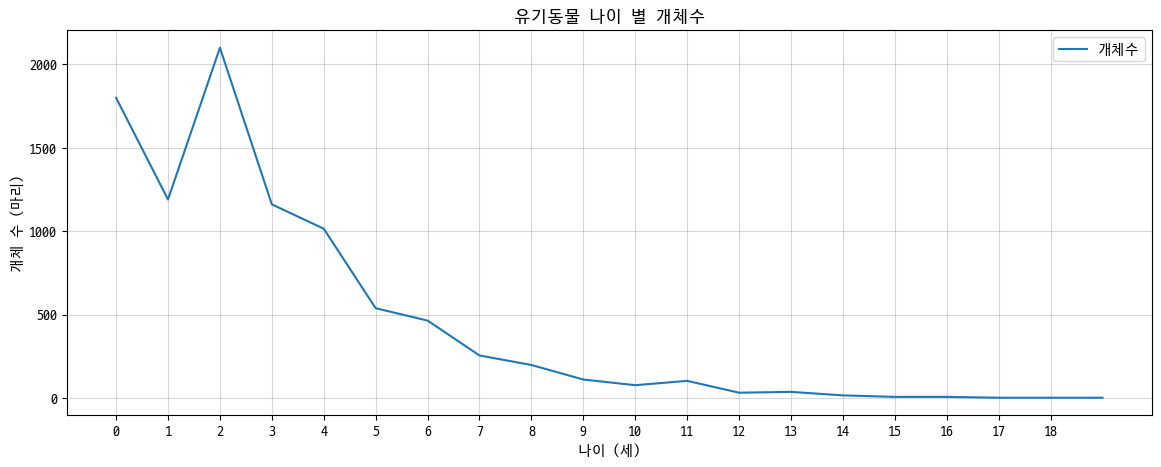

In [75]:
## [가설 4] 나이가 어린(1살 이하) 동물들의 수가 많을 것이다
abandoned.groupby('나이').size().plot(
    figsize=(14 ,5),
    xticks=(range(0, len(abandoned.groupby('나이').size()))),
    label='개체수',
    title='유기동물 나이 별 개체수',
    
)
plt.xlabel('나이 (세)')
plt.ylabel('개체 수 (마리)')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## [가설 4] 나이가 1살 이하인 동물들의 수가 많을 것이다
- 유기동물의 나이는 2살이 1,620마리로 가장 높았으며, 0살 1,472마리, 1살 1,062마리 순으로 많았다.
- 

In [38]:
abandoned.groupby('상태').size()

상태
보호중        1695
종료(기증)      512
종료(반환)     1444
종료(방사)       46
종료(안락사)    2085
종료(입양)     1884
종료(자연사)    1461
dtype: int64

In [82]:
end_detail = abandoned[abandoned.상태.str.contains('종료')]
end_detail[:2]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
23,고양시,2023-05,종료(반환),개,믹스견,3,14.0,M,Y
40,포천시,2023-05,종료(반환),개,포메라니안,4,4.0,F,Q


In [83]:
end_detail.loc[:, '상태'] = end_detail.상태.str.replace('종료', '').str.replace('(', '').str.replace(')', '')
end_detail[:3]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
23,고양시,2023-05,반환,개,믹스견,3,14.0,M,Y
40,포천시,2023-05,반환,개,포메라니안,4,4.0,F,Q
46,고양시,2023-05,반환,개,말티즈,6,3.9,M,Y


- '입양'은 새로운 가족에 입양
- '반환'은 원래 주인에게 반환
- '자연사'는 유기동물 보호소 등에서 질병으로 죽는 경우
- '안락사'는 고통을 덜어주거나 개체 수 조절을 위해서 약품 등으로 안락사 되는 경우
- '방사'는 고양이에 한해 취해지는 조치로 길거리로 다시 돌려보내지는 경우
- '기증'은 기관이나 단체 등에게 보내지는 경우를 뜻한다.

<Axes: xlabel='상태'>

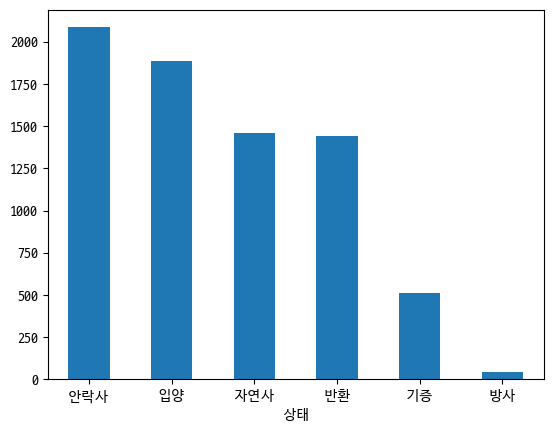

In [98]:
end_detail.groupby('상태').size().sort_values(ascending=False).plot(
    kind='bar',
    rot=0,
)

<Axes: title={'center': '보호 종료 사유'}>

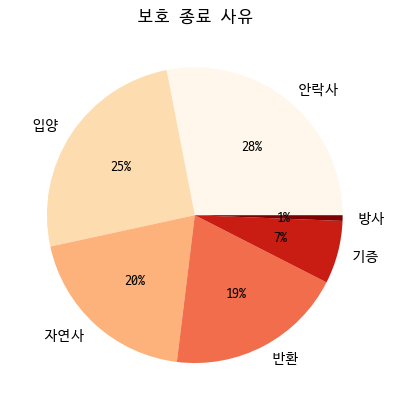

In [123]:
end_detail.groupby('상태').size().sort_values(ascending=False).plot(
    kind='pie',
    autopct='%.f%%',
    title='보호 종료 사유',
    colormap='OrRd',
    
)

##  [가설 5] 보호 종료 사유는 안락사의 비율이 월등히 높을 것이다
- 보호 종료 사유로는 안락사가 28%로 가장 높았고, 입양이 25%, 자연사 20%, 반환 19%, 기증 7%, 방사 1% 순이었다.
- 안락사 비율이 상당히 높을 것으로 예상했으나, 실제로는 입양 비율과 큰 차이가 없었다.

In [55]:
abandoned[:5]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
0,오산시,2023-05,보호중,고양이,한국 고양이,0,0.11,Q,N
1,오산시,2023-05,보호중,고양이,한국 고양이,0,0.10,Q,N
2,남양주시,2023-05,보호중,개,셰퍼드,3,24.00,F,N
3,남양주시,2023-05,보호중,개,셰퍼드,3,27.00,M,N
4,성남시,2023-05,보호중,고양이,터키시 앙고라,1,1.10,F,Q


유기동물의 성별과 중성화여부는 입양에 영향을 미칠것이다  
성별별 중성화별 입양률

In [86]:
adoption = end_detail[end_detail.상태 == '입양']
adoption

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
318,수원시,2023-05,입양,고양이,한국 고양이,0,0.38,Q,N
726,용인시,2023-05,입양,고양이,한국 고양이,0,0.66,F,N
729,용인시,2023-05,입양,고양이,한국 고양이,0,0.50,F,N
743,용인시,2023-05,입양,고양이,한국 고양이,0,0.45,F,N
757,화성시,2023-05,입양,고양이,한국 고양이,0,0.10,Q,Q
...,...,...,...,...,...,...,...,...,...
9103,여주시,2022-11,입양,고양이,한국 고양이,2,0.50,M,N
9119,양평군,2022-11,입양,개,믹스견,2,1.00,Q,N
9121,파주시,2022-11,입양,개,믹스견,4,11.00,F,N
9122,파주시,2022-11,입양,고양이,한국 고양이,2,1.88,M,N


In [146]:
abandoned[abandoned.상태.str.contains('종료')]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
23,고양시,2023-05,종료(반환),개,믹스견,3,14.00,M,Y
40,포천시,2023-05,종료(반환),개,포메라니안,4,4.00,F,Q
46,고양시,2023-05,종료(반환),개,말티즈,6,3.90,M,Y
52,성남시,2023-05,종료(반환),개,라이카,4,21.00,M,N
60,성남시,2023-05,종료(자연사),고양이,한국 고양이,0,0.16,M,N
...,...,...,...,...,...,...,...,...,...
9122,파주시,2022-11,종료(입양),고양이,한국 고양이,2,1.88,M,N
9123,파주시,2022-11,종료(입양),고양이,한국 고양이,2,0.50,F,N
9124,파주시,2022-11,종료(안락사),개,믹스견,4,16.90,F,N
9125,화성시,2022-11,종료(기증),개,믹스견,8,4.00,M,Q


In [4]:
abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.성별 == 'F')]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
726,용인시,2023-05,종료(입양),고양이,한국 고양이,0,0.66,F,N
729,용인시,2023-05,종료(입양),고양이,한국 고양이,0,0.50,F,N
743,용인시,2023-05,종료(입양),고양이,한국 고양이,0,0.45,F,N
810,성남시,2023-04,종료(입양),기타축종,토끼,0,0.38,F,N
837,수원시,2023-04,종료(입양),개,시츄,6,3.80,F,Q
...,...,...,...,...,...,...,...,...,...
9080,안산시,2022-11,종료(입양),개,믹스견,8,3.50,F,Q
9087,성남시,2022-11,종료(입양),고양이,한국 고양이,2,1.00,F,N
9097,부천시,2022-11,종료(입양),개,포메라니안,3,3.70,F,Q
9121,파주시,2022-11,종료(입양),개,믹스견,4,11.00,F,N


In [5]:
abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.성별 == 'M')]

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
789,수원시,2023-05,종료(입양),개,말티즈,4,3.50,M,N
861,고양시,2023-04,종료(입양),개,믹스견,3,19.00,M,Q
873,용인시,2023-04,종료(입양),고양이,브리티시 쇼트헤어,7,5.30,M,Y
874,성남시,2023-04,종료(입양),개,믹스견,1,3.50,M,N
888,광주시,2023-04,종료(입양),고양이,한국 고양이,0,0.20,M,N
...,...,...,...,...,...,...,...,...,...
9052,이천시,2022-11,종료(입양),개,라브라도 리트리버,4,25.00,M,N
9057,오산시,2022-11,종료(입양),고양이,러시안 블루,2,4.60,M,Y
9096,평택시,2022-11,종료(입양),개,웰시 코기 펨브로크,9,8.00,M,Y
9103,여주시,2022-11,종료(입양),고양이,한국 고양이,2,0.50,M,N


In [36]:
adoption_female_rate = len(abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.성별 == 'F')]) / len(abandoned[abandoned.상태.str.contains('종료')]) * 100

In [37]:
adoption_male_rate = len(abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.성별 == 'M')]) / len(abandoned[abandoned.상태.str.contains('종료')]) * 100

In [38]:
altered_y_rate = len(abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.중성화여부 == 'Y')]) / len(abandoned[abandoned.상태.str.contains('종료')]) * 100

In [39]:
altered_n_rate = len(abandoned[(abandoned.상태.str.contains('입양')) & (abandoned.중성화여부 == 'N')]) / len(abandoned[abandoned.상태.str.contains('종료')]) * 100

In [40]:
dic_rate = {'수컷': adoption_male_rate, 
            '암컷': adoption_female_rate,
            '중성화': altered_y_rate,
            '비중성화': altered_n_rate,
           }
dic_rate

{'수컷': 12.17707212055974,
 '암컷': 11.881054897739505,
 '중성화': 1.9375672766415502,
 '비중성화': 16.89989235737352}

In [31]:
abandoned[abandoned.품종 == '기타축종'].품종상세.value_counts()

품종상세
알수없음      31
토끼        26
닭         18
햄스터       14
흑염소        8
앵무새        5
염소         5
고슴도치       4
사랑앵무       3
골든 햄스터     2
거위         2
사향오리       2
갈색거위       1
공작새        1
은계         1
칠면조        1
앵무         1
기니피그       1
백봉 오골계     1
새          1
꿩(금계)      1
라쿤         1
아마존앵무      1
황금계        1
거북이        1
백한         1
돼지         1
모란앵무       1
Name: count, dtype: int64

In [29]:
abandoned.loc[(abandoned.품종 == '기타축종') & (abandoned.품종상세 == ''), '품종상세'] = '알수없음'

In [30]:
abandoned[abandoned.품종 == '기타축종']

,시군명,접수일자,상태,품종,품종상세,나이,체중,성별,중성화여부
81,성남시,2023-05,종료(자연사),기타축종,햄스터,2,0.01,Q,N
220,고양시,2023-05,보호중,기타축종,앵무새,2,0.03,Q,Q
224,평택시,2023-05,보호중,기타축종,골든 햄스터,0,0.01,F,N
236,평택시,2023-05,보호중,기타축종,골든 햄스터,0,0.01,M,N
304,평택시,2023-05,보호중,기타축종,햄스터,0,0.05,Q,N
...,...,...,...,...,...,...,...,...,...
8767,평택시,2022-11,종료(입양),기타축종,알수없음,2,1.00,M,Y
8773,고양시,2022-11,종료(입양),기타축종,모란앵무,2,0.04,Q,Q
8800,안양시,2022-11,종료(입양),기타축종,알수없음,2,0.30,Q,Q
8820,남양주시,2022-11,종료(반환),기타축종,알수없음,4,0.50,Q,Q


In [16]:
abandoned.품종상세 = abandoned.품종상세.str.lstrip()

In [42]:
rate = pd.DataFrame({'입양률': dic_rate})
rate = rate.reindex(['수컷', '암컷', '중성화', '비중성화'])
rate.T

,수컷,암컷,중성화,비중성화
입양률,12.177072,11.881055,1.937567,16.899892


'#E6E6FA', '#FFF0F5', '#E0FFFF', 

<Axes: title={'center': '성별별 중성화별 입양률'}, ylabel='입양률 (%)'>

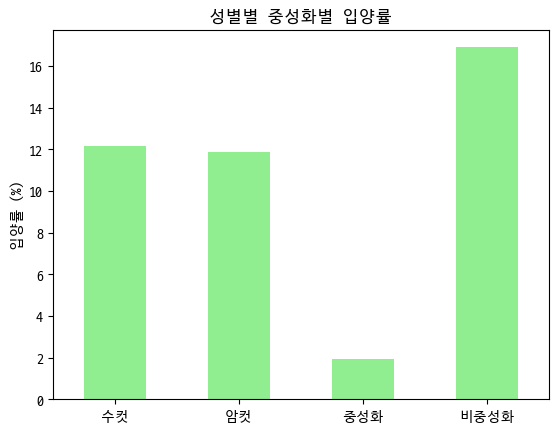

In [43]:
rate.plot(
    kind='bar',
    rot=0,
    ylabel='입양률 (%)',
    legend=False,
    color=['#90EE90'],
    title='성별별 중성화별 입양률'
)

## [가설6] 유기동물의 성별과 중성화여부는 입양에 영향을 미칠것이다
유기동물의 성별과 중성화 여부에 따른 입양률 데이터를 살펴보면, 수컷의 입양률은 약 12.2%, 암컷의 입양률은 약 11.9%로 거의 비슷한 양상을 보였다.

그러나 중성화 여부에 따른 입양률은 상이한 결과를 보였다. 중성화된 동물의 입양률은 약 1.9%로 낮았으며, 비중성화된 동물의 입양률은 약 16.9%로 월등히 높게 나타났다.
